## Doing Bayesian Linear Regression the Hackers way

**Goal:** Show that bayesian linear regression is not magic

**Usage:** 

**Dataset:** Artificial Data

**Content:**

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0  
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [3]:
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

In [72]:
bmin=amin=-3;bmax=amax=3;xmin = -10;xmax = +10;ymin=-30;ymax=30;
nbins_c=30

In [73]:
a_ml = 2.35534936; b_ml=-0.48331204 ## TODO Estimate e.g. usng 

### Creation of the data set

x  (4, 1)    (4,)


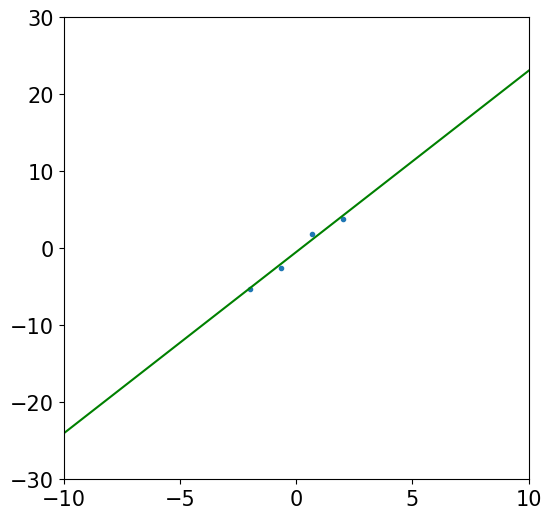

In [74]:
fig = plt.figure(figsize=(6,6))
num = 4
def createData(save=True):
    #num = 10
    np.random.seed(42)
    x = np.random.normal(0,1,(num,1))
    x = np.linspace(-2,2,num=num).reshape((num,1))
    y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,1,num) 
    plt.scatter(x,y, marker='.')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='g', alpha = 1)
    print("x ", x.shape, "  ", y.shape)
    if save:
        d = np.transpose(np.vstack((x[:,0],y)))
        np.savetxt('data_blr_{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e');     
    return (x,y)
x,y = createData()

In [75]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients: \n', a_ml)
print('Coefficients: \n', b_ml)

Coefficients: 
 [2.36135856]
Coefficients: 
 -0.5304106967530541


$p(y|x,a,b)$

In [76]:
def pre_distribution(a,b):
    """
        Return the predictive distribution for a, b
    """
    canvas0 = np.zeros((nbins_c, nbins_c), dtype=np.float32) #The complete img
    for j,x_ in enumerate(np.linspace(xmin, xmax, nbins_c)):
        py = tfd.Normal(loc=a*x_+b,scale=1)
        for i,y_ in enumerate(np.linspace(ymin, ymax, nbins_c)):
                canvas0[nbins_c-i-1,j] = py.prob(y_)
    return canvas0

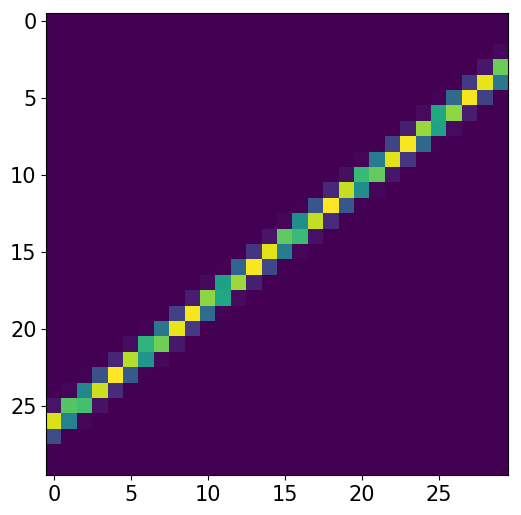

In [77]:
fig = plt.figure(figsize=(6,6))
plt.imshow(pre_distribution(a_ml, b_ml))

* Don't put all egg in one basket
* While it's best to use the line with the highest prob. why not also take other solutions into account?
* OK maybe not with full weight
* The more prob. they are the more we take them into account
* Idea: Sample `a` and `b` randomly (uniform). Always take the parameters with the hightest probabiliy.
    * If less then highest only take them in a certain fraction. Choose this proportional to prob.

In [78]:
ytensor = y.reshape([len(y),1])
def unnormalized_likehihood(w):
    y_prob = tfd.Independent(tfd.Normal(loc=x*w[0]+w[1], scale=1.0), reinterpreted_batch_ndims=1)
    return (tf.reduce_sum(tf.reduce_sum(y_prob.log_prob(ytensor))))

In [79]:
nbins = 10
bmin=-3
bmax=3
amin=0;amax=5
ai, bi = np.mgrid[amin:amax:nbins*1j, bmin:bmax:nbins*1j] #wtf is j?
ws = np.vstack([ai.flatten(), bi.flatten()])
unpost = np.zeros((nbins*nbins))
for i in range((nbins*nbins)):
    unpost[i] = unnormalized_likehihood(tf.Variable([[ws[0,i]],[ws[1,i]]],dtype=tf.float32))/num
unpost = np.exp(unpost.reshape(ai.shape))
post = unpost / np.sum(unpost) #<-- We normalize

Text(0.5, 1.0, 'Likelihood')

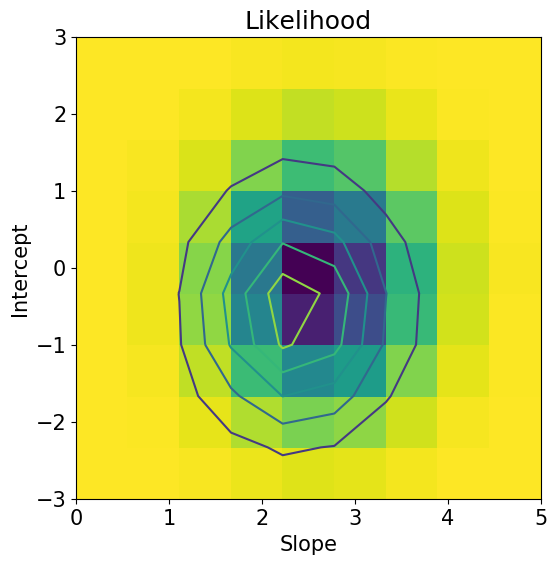

In [80]:
fig = plt.figure(figsize=(6,6))
plt.pcolormesh(ai, bi, -unpost, shading='none',cmap="viridis")
plt.contour(ai, bi, post)
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('Likelihood')

In [81]:
def toBin(a, amin, amax):
    a = np.clip(a, amin, amax)
    return int(0.99999*(a - amin)/(amax-amin) * nbins)

def getProb(a,b):
    return post[toBin(a,amin,amax),toBin(b,bmin,bmax)]

8.506688084761157e-06
3.534030634501312e-05
9.413688750956024e-05
0.00016077906482640387
0.00017606787722077805
0.00012362607126022951
5.56571513260115e-05
1.60661574526907e-05
2.973601639104563e-06
3.528854030514314e-07
0.00011140537023017811
0.00046282361813144627
0.001232835234971177
0.0021055963335877073
0.002305819626363895
0.0016190329422704989
0.0007288970248337699
0.00021040566527059237
3.8942910357199205e-05
4.62146561343023e-06
0.0007348205359200067
0.0030527460068496748
0.008131682325221557
0.013888337905805877
0.015208994055482329
0.01067900633383543
0.004807745165347459
0.0013878182299048676
0.0002568641906564951
3.0482772896436926e-05
0.0024411046563081007
0.010141352757961965
0.027013796362593052
0.046137646832821996
0.0505249164819773
0.03547611140351059
0.015971534999235093
0.004610388199691998
0.0008533136204002897
0.00010126514731384392
0.004084336059759767
0.016968015907272205
0.045198164124251046
0.07719526550277134
0.08453583158378486
0.05935688908870703
0.0267227

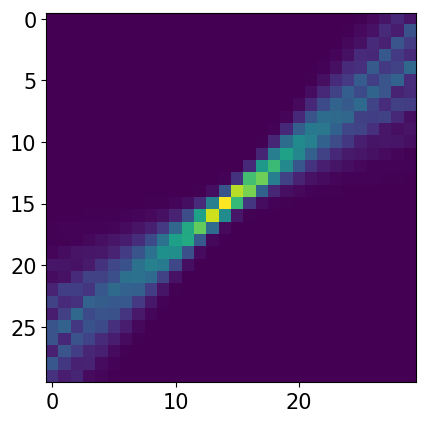

In [82]:
canvas = np.zeros((nbins_c, nbins_c), dtype=np.float32) #The complete img
for a in np.linspace(amin, amax, nbins):
    for b in np.linspace(bmin, bmax, nbins):
        p = getProb(a,b)
        print(p)
        canvas += pre_distribution(a,b) * getProb(a,b) 
plt.imshow(canvas)

### Poor man's bayes by sampling

In [15]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients: \n', a_ml)
print('Coefficients: \n', b_ml)

Coefficients: 
 [2.36135856]
Coefficients: 
 -0.5304106967530541


In [16]:
from skimage.draw import line_aa
img_line = np.zeros((5, 5), dtype=np.float32) #The line
rr,cc,val = line_aa(0,0,2,4)
img_line[rr,cc] = val
img_line

array([[1.        , 0.5527864 , 0.10557282, 0.        , 0.        ],
       [0.10557282, 0.5527864 , 1.        , 0.5527864 , 0.10557282],
       [0.        , 0.        , 0.10557282, 0.5527864 , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

### Towards the predictive distribution.

Another way to reproduce the figure above is to weight every curve by its probability. So that curves which are very likely, have high rate curves which are very unlikely have a low rate.

We now simply loop over all values of a and b. Calculate the probability of the resulting curve and draw a line weighted with the appropriate probability.

In [17]:
for a in range(nbins): #looping over the bins corresponding to amin, amax
    for b in range(nbins):
        p = post[a,b]
        ai[a]

In [18]:
xmin, xmax

(-10, 10)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


(0.4980392156862745, 50)

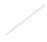

In [20]:
import numpy
 
def fig2data (fig):
    fig.canvas.draw ( )
    # Get the RGB buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = numpy.fromstring( fig.canvas.tostring_rgb(), dtype=numpy.uint8 )
    buf.shape = ( w, h, 3 )
    buf = numpy.roll ( buf, 3, axis = 2 )
    return buf

fig = plt.figure(figsize=(nbins/10,nbins/10),dpi=10,)
plt.plot([-10.0, 10.0], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='gray', alpha = 1)
plt.xlim((-10,10))
plt.ylim((-30,30))
plt.axis('off')

dat = (255 - fig2data(fig)[:,:,0])/255.0 #BW one channel is good enough
np.max(dat),nbins
#dat = (255-dat) / 255.0 #in range 0-255 with no line 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

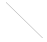

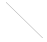

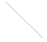

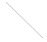

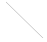

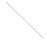

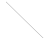

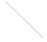

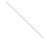

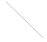

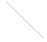

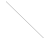

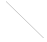

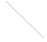

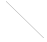

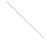

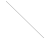

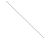

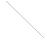

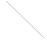

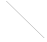

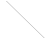

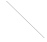

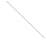

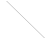

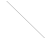

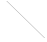

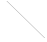

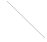

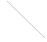

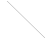

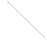

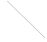

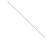

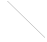

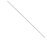

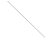

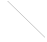

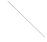

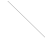

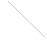

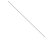

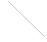

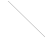

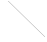

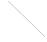

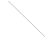

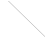

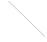

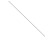

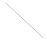

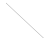

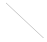

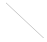

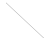

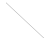

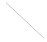

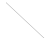

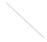

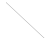

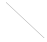

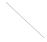

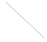

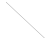

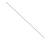

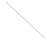

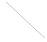

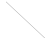

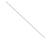

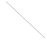

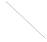

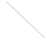

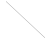

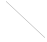

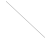

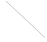

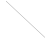

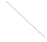

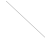

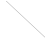

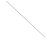

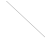

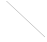

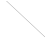

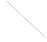

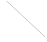

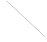

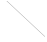

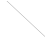

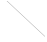

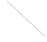

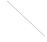

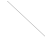

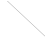

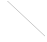

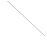

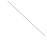

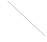

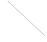

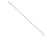

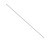

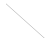

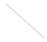

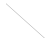

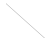

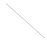

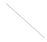

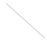

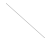

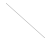

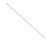

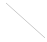

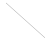

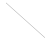

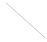

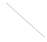

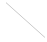

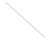

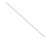

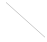

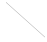

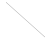

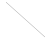

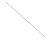

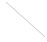

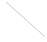

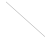

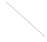

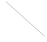

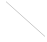

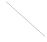

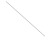

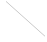

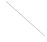

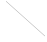

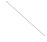

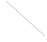

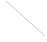

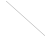

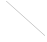

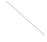

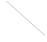

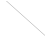

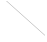

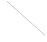

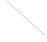

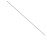

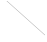

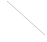

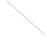

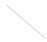

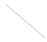

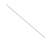

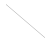

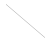

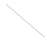

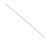

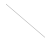

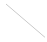

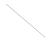

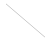

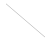

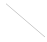

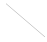

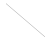

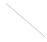

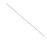

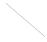

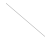

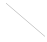

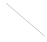

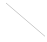

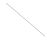

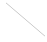

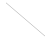

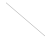

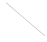

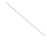

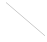

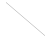

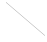

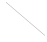

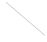

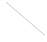

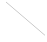

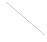

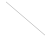

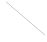

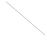

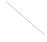

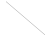

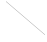

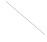

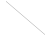

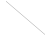

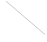

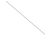

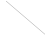

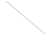

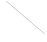

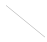

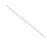

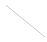

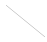

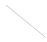

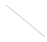

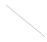

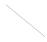

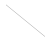

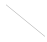

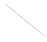

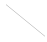

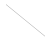

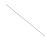

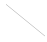

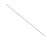

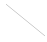

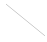

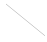

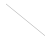

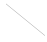

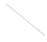

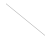

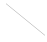

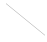

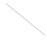

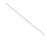

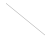

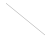

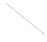

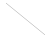

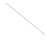

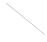

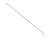

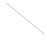

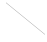

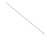

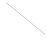

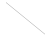

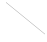

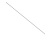

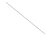

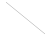

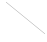

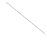

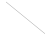

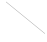

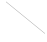

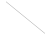

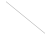

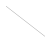

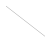

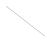

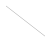

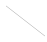

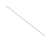

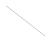

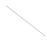

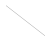

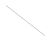

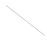

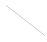

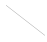

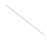

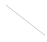

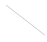

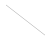

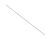

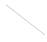

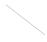

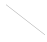

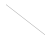

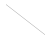

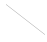

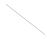

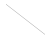

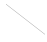

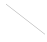

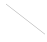

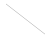

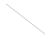

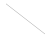

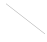

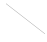

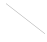

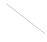

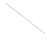

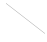

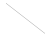

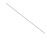

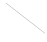

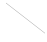

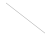

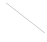

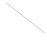

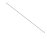

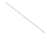

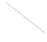

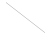

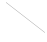

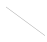

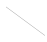

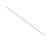

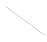

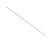

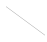

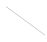

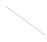

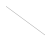

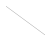

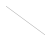

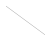

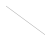

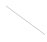

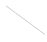

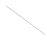

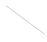

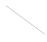

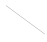

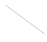

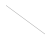

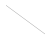

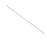

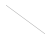

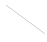

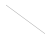

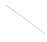

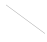

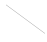

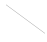

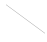

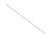

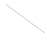

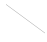

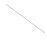

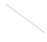

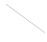

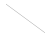

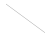

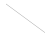

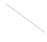

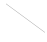

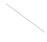

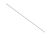

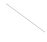

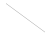

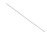

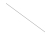

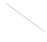

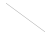

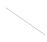

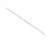

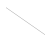

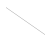

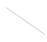

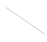

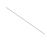

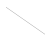

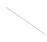

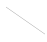

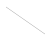

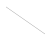

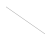

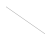

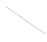

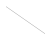

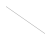

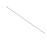

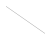

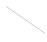

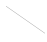

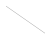

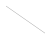

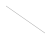

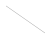

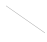

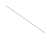

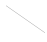

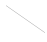

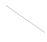

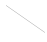

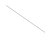

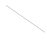

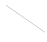

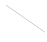

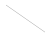

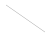

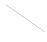

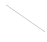

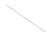

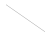

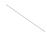

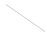

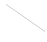

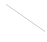

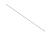

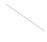

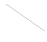

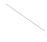

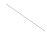

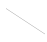

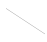

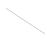

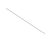

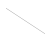

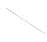

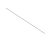

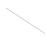

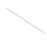

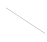

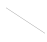

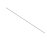

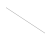

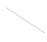

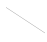

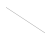

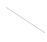

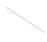

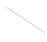

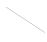

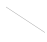

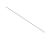

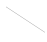

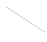

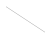

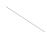

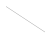

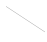

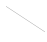

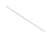

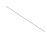

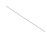

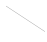

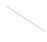

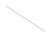

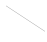

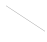

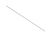

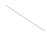

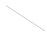

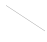

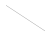

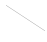

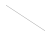

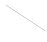

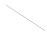

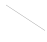

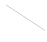

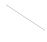

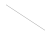

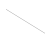

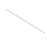

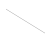

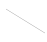

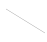

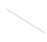

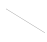

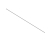

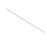

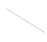

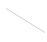

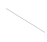

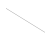

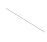

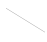

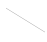

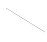

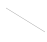

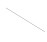

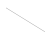

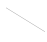

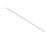

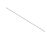

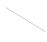

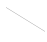

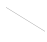

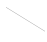

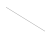

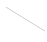

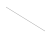

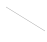

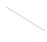

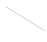

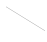

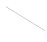

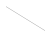

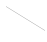

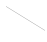

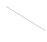

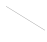

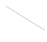

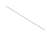

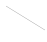

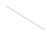

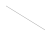

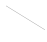

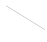

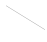

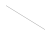

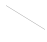

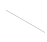

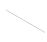

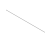

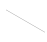

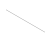

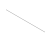

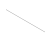

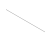

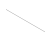

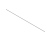

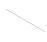

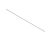

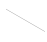

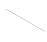

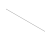

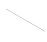

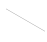

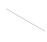

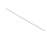

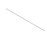

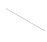

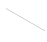

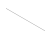

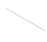

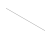

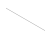

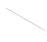

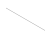

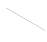

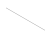

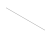

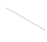

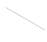

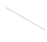

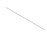

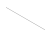

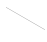

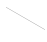

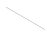

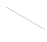

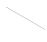

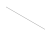

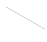

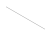

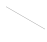

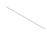

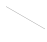

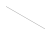

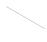

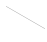

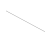

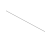

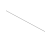

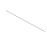

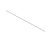

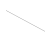

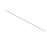

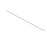

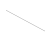

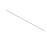

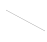

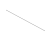

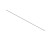

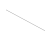

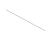

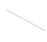

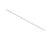

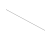

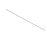

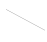

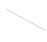

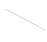

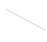

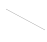

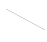

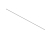

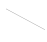

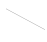

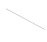

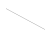

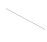

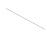

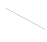

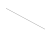

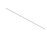

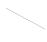

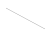

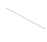

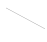

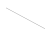

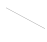

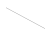

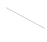

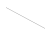

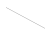

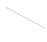

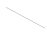

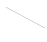

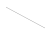

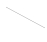

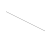

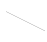

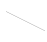

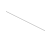

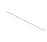

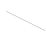

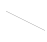

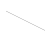

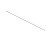

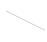

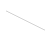

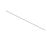

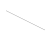

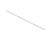

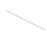

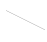

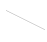

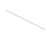

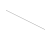

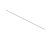

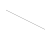

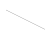

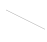

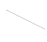

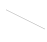

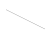

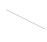

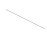

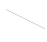

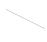

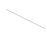

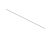

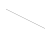

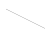

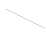

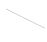

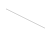

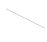

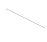

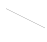

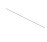

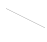

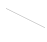

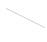

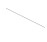

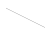

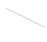

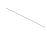

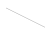

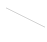

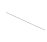

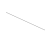

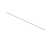

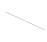

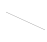

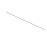

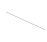

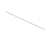

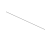

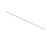

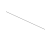

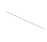

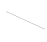

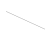

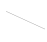

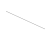

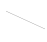

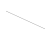

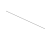

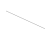

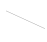

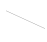

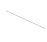

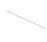

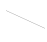

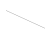

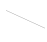

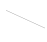

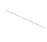

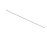

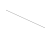

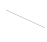

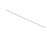

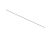

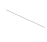

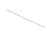

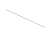

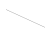

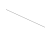

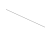

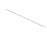

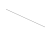

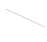

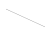

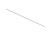

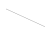

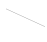

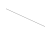

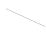

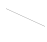

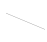

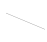

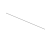

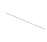

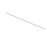

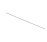

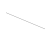

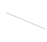

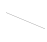

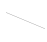

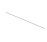

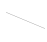

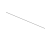

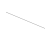

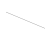

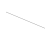

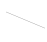

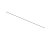

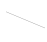

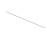

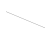

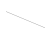

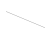

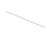

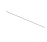

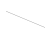

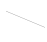

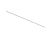

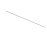

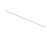

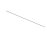

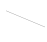

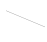

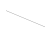

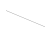

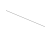

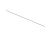

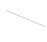

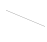

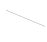

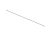

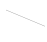

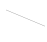

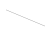

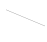

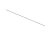

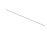

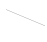

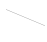

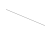

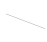

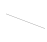

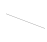

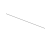

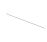

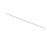

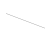

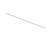

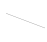

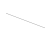

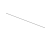

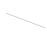

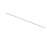

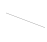

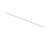

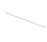

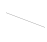

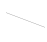

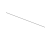

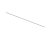

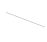

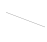

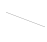

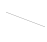

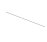

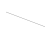

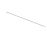

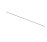

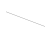

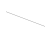

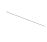

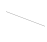

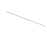

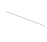

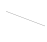

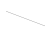

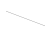

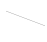

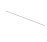

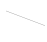

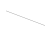

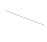

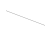

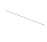

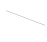

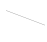

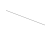

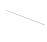

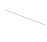

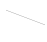

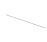

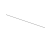

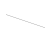

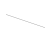

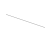

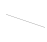

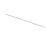

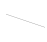

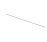

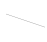

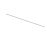

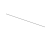

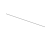

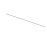

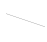

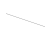

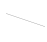

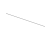

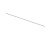

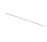

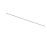

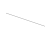

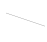

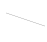

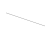

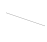

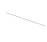

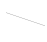

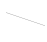

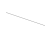

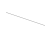

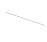

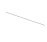

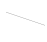

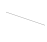

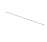

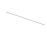

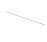

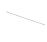

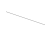

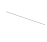

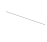

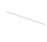

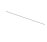

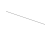

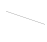

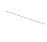

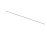

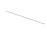

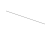

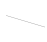

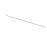

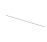

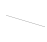

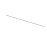

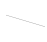

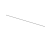

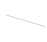

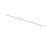

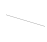

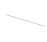

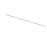

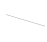

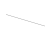

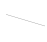

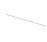

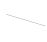

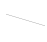

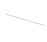

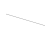

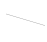

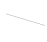

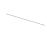

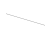

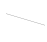

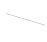

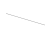

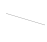

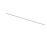

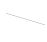

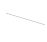

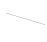

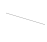

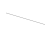

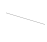

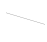

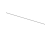

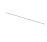

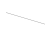

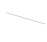

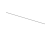

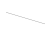

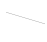

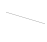

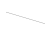

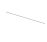

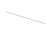

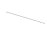

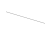

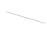

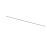

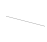

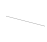

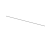

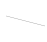

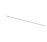

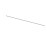

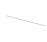

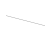

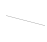

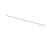

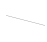

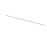

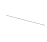

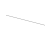

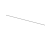

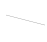

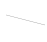

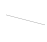

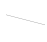

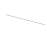

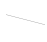

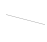

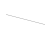

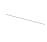

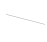

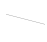

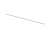

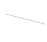

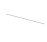

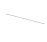

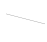

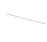

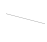

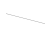

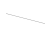

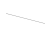

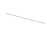

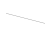

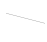

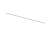

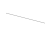

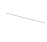

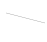

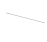

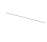

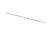

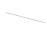

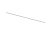

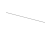

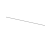

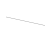

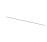

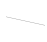

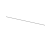

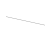

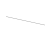

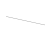

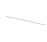

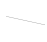

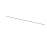

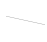

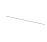

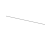

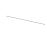

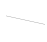

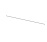

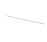

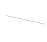

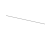

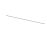

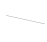

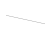

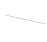

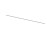

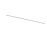

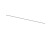

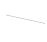

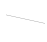

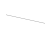

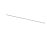

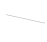

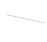

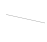

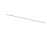

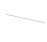

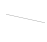

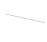

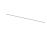

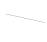

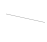

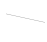

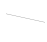

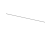

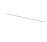

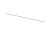

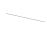

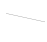

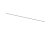

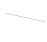

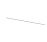

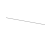

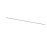

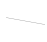

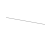

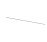

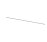

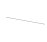

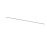

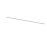

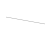

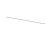

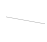

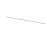

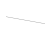

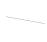

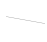

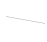

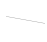

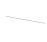

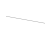

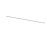

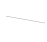

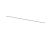

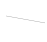

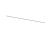

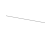

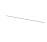

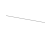

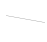

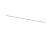

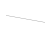

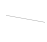

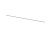

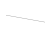

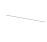

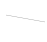

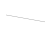

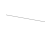

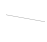

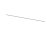

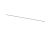

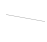

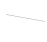

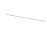

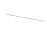

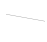

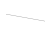

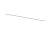

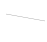

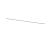

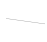

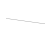

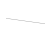

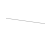

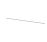

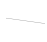

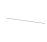

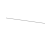

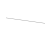

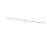

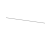

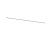

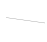

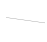

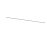

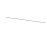

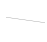

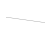

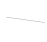

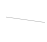

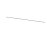

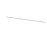

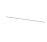

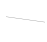

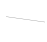

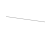

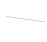

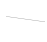

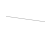

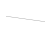

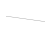

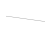

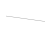

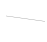

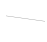

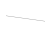

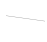

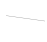

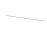

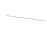

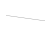

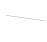

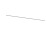

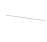

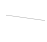

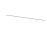

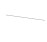

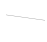

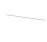

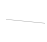

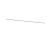

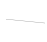

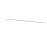

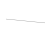

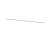

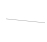

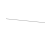

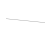

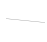

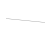

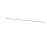

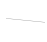

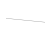

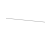

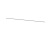

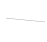

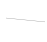

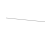

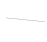

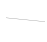

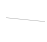

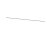

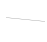

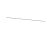

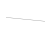

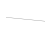

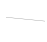

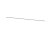

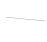

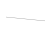

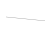

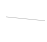

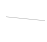

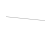

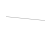

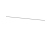

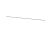

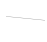

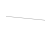

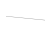

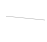

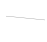

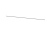

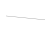

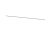

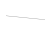

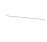

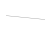

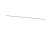

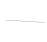

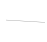

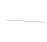

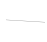

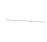

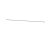

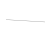

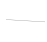

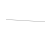

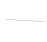

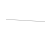

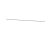

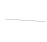

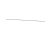

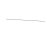

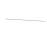

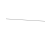

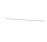

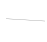

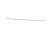

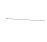

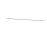

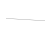

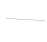

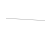

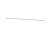

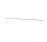

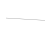

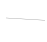

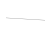

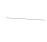

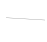

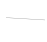

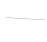

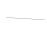

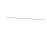

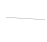

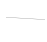

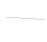

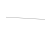

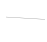

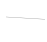

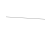

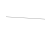

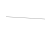

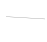

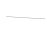

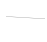

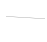

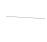

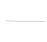

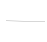

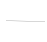

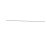

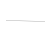

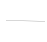

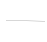

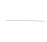

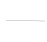

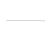

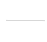

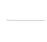

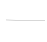

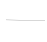

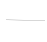

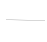

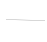

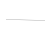

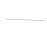

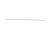

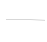

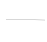

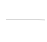

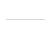

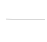

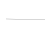

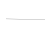

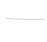

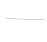

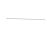

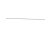

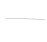

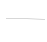

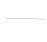

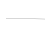

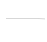

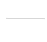

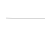

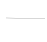

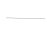

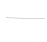

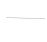

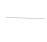

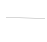

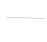

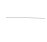

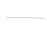

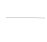

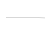

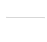

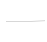

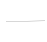

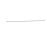

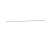

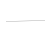

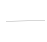

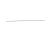

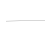

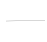

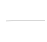

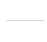

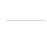

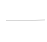

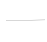

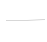

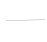

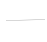

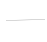

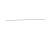

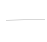

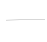

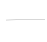

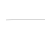

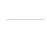

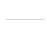

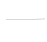

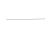

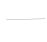

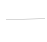

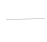

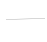

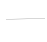

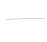

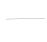

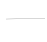

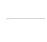

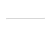

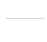

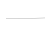

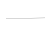

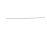

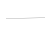

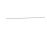

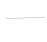

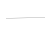

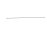

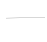

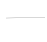

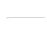

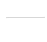

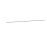

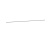

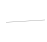

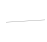

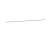

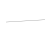

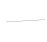

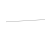

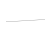

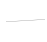

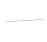

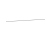

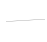

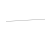

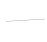

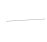

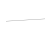

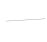

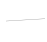

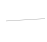

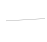

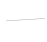

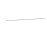

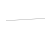

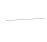

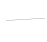

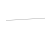

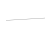

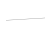

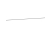

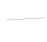

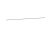

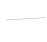

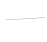

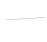

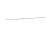

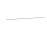

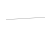

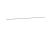

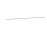

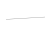

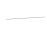

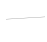

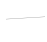

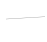

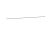

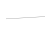

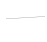

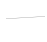

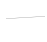

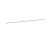

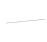

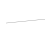

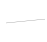

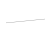

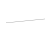

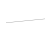

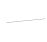

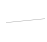

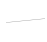

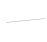

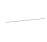

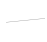

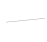

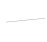

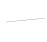

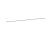

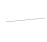

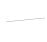

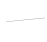

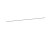

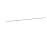

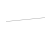

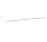

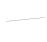

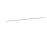

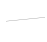

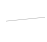

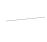

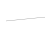

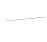

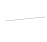

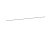

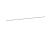

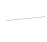

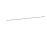

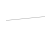

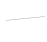

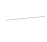

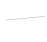

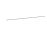

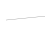

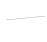

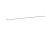

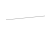

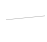

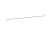

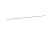

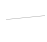

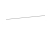

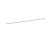

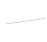

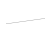

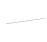

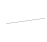

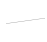

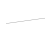

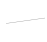

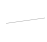

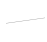

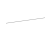

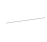

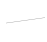

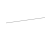

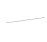

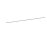

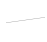

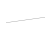

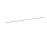

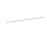

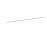

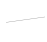

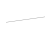

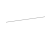

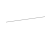

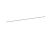

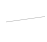

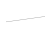

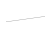

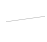

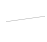

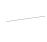

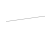

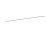

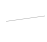

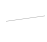

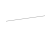

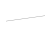

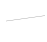

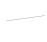

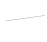

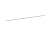

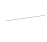

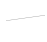

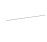

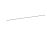

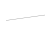

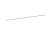

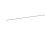

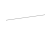

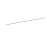

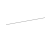

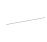

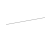

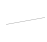

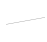

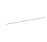

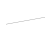

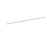

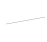

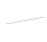

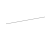

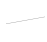

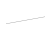

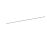

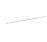

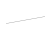

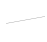

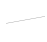

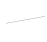

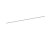

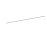

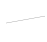

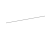

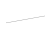

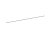

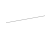

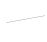

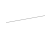

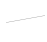

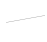

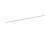

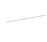

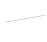

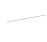

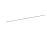

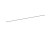

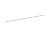

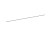

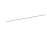

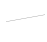

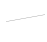

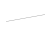

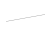

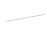

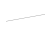

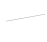

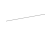

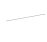

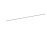

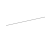

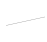

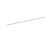

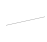

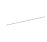

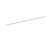

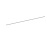

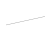

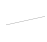

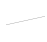

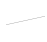

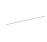

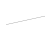

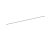

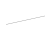

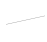

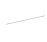

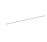

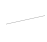

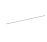

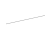

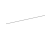

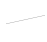

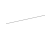

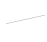

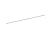

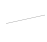

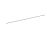

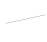

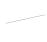

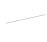

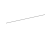

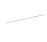

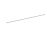

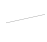

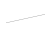

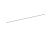

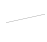

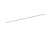

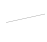

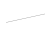

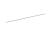

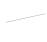

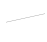

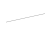

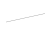

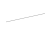

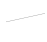

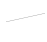

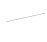

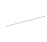

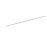

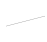

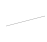

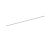

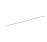

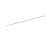

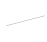

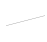

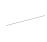

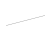

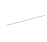

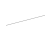

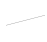

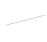

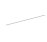

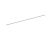

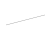

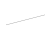

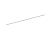

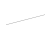

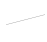

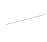

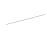

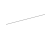

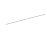

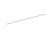

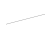

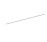

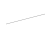

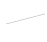

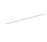

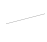

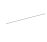

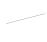

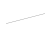

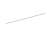

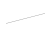

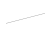

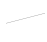

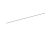

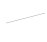

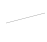

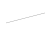

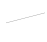

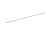

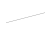

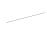

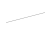

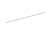

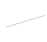

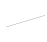

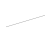

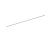

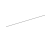

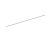

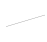

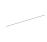

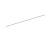

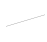

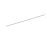

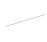

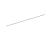

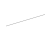

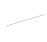

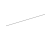

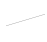

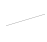

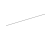

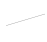

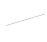

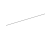

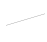

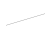

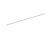

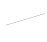

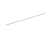

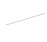

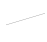

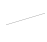

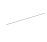

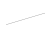

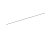

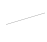

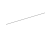

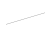

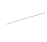

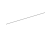

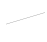

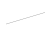

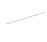

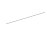

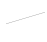

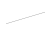

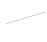

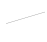

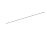

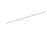

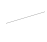

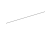

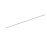

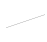

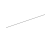

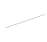

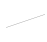

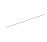

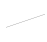

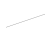

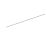

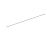

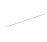

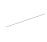

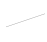

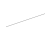

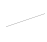

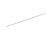

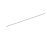

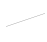

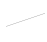

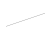

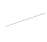

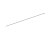

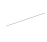

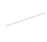

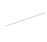

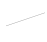

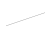

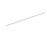

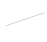

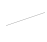

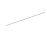

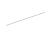

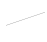

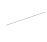

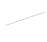

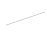

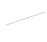

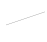

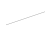

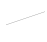

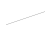

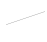

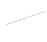

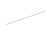

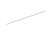

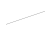

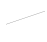

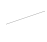

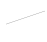

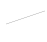

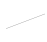

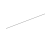

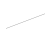

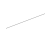

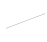

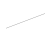

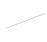

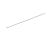

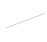

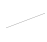

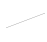

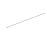

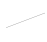

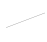

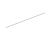

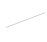

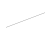

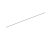

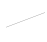

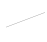

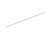

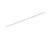

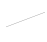

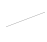

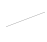

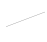

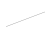

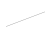

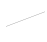

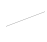

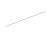

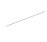

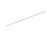

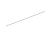

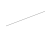

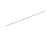

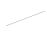

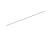

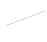

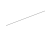

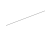

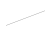

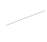

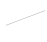

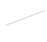

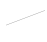

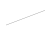

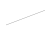

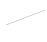

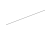

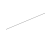

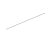

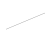

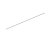

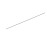

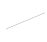

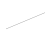

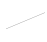

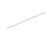

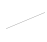

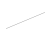

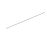

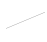

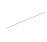

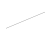

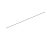

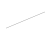

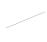

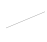

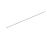

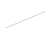

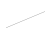

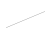

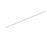

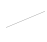

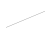

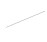

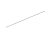

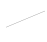

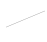

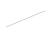

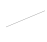

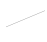

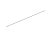

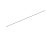

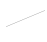

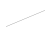

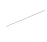

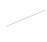

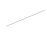

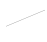

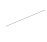

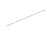

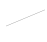

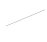

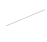

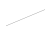

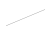

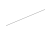

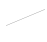

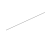

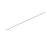

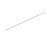

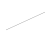

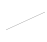

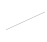

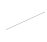

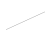

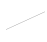

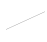

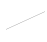

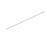

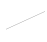

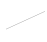

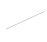

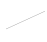

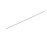

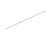

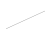

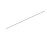

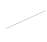

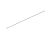

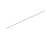

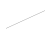

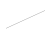

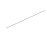

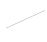

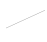

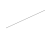

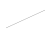

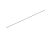

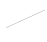

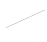

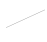

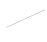

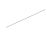

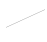

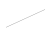

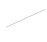

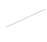

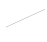

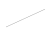

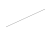

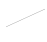

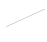

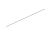

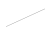

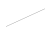

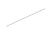

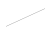

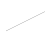

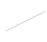

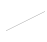

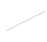

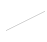

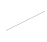

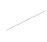

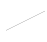

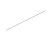

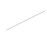

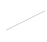

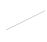

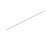

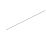

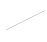

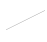

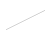

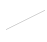

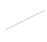

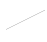

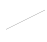

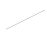

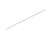

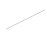

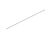

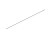

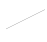

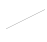

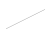

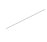

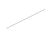

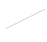

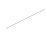

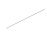

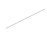

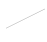

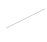

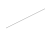

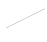

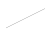

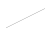

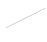

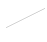

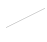

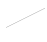

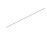

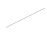

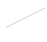

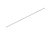

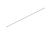

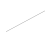

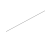

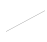

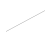

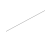

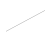

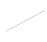

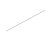

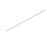

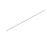

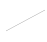

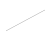

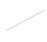

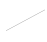

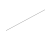

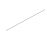

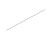

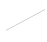

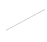

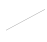

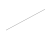

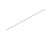

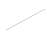

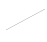

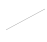

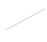

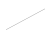

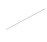

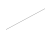

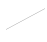

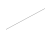

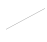

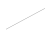

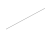

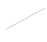

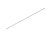

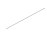

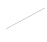

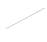

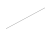

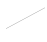

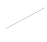

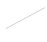

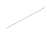

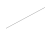

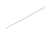

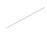

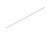

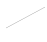

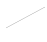

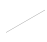

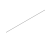

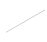

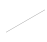

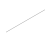

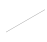

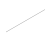

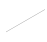

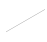

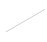

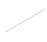

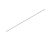

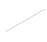

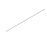

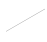

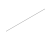

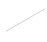

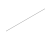

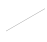

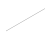

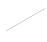

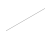

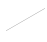

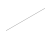

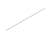

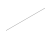

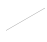

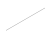

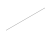

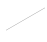

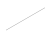

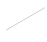

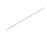

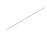

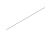

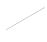

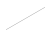

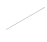

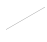

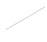

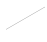

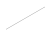

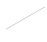

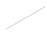

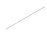

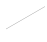

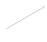

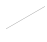

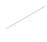

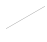

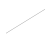

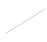

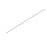

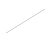

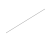

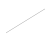

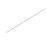

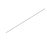

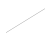

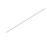

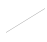

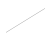

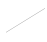

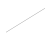

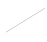

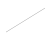

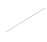

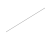

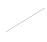

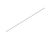

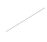

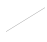

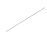

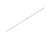

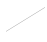

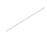

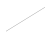

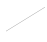

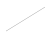

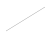

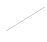

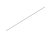

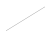

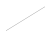

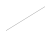

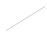

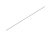

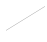

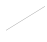

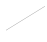

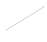

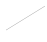

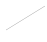

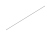

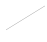

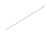

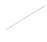

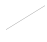

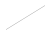

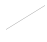

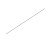

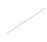

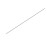

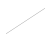

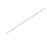

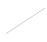

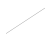

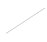

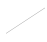

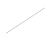

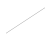

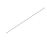

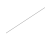

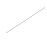

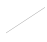

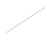

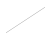

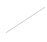

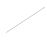

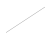

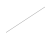

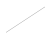

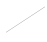

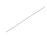

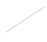

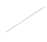

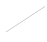

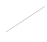

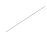

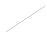

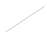

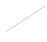

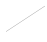

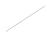

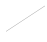

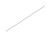

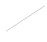

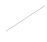

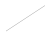

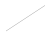

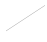

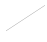

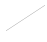

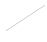

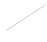

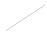

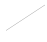

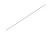

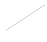

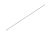

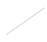

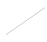

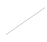

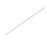

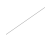

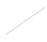

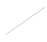

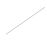

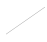

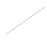

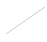

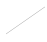

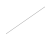

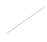

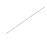

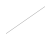

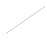

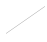

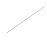

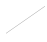

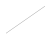

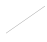

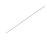

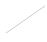

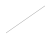

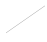

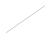

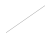

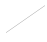

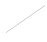

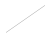

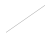

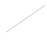

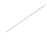

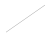

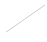

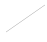

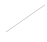

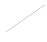

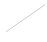

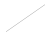

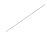

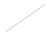

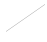

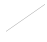

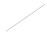

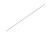

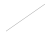

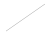

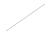

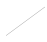

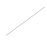

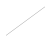

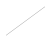

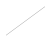

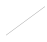

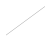

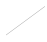

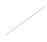

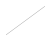

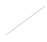

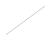

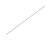

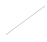

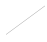

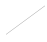

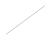

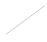

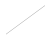

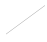

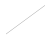

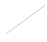

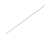

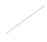

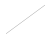

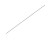

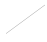

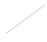

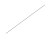

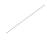

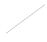

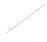

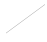

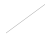

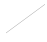

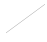

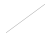

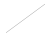

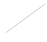

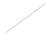

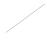

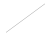

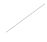

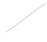

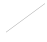

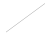

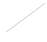

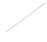

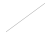

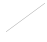

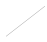

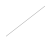

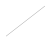

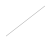

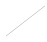

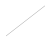

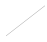

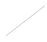

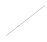

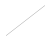

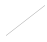

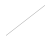

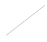

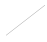

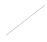

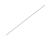

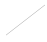

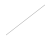

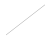

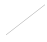

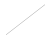

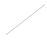

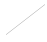

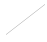

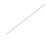

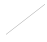

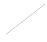

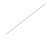

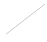

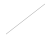

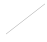

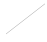

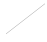

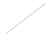

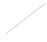

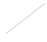

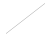

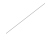

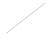

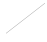

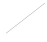

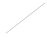

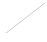

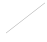

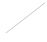

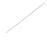

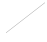

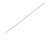

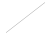

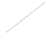

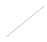

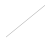

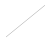

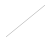

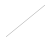

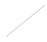

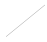

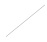

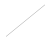

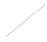

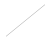

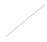

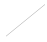

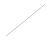

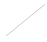

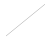

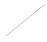

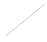

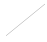

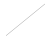

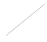

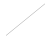

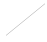

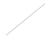

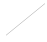

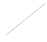

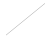

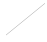

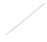

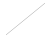

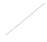

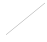

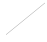

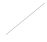

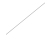

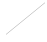

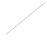

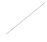

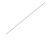

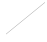

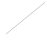

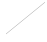

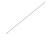

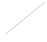

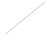

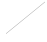

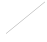

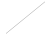

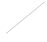

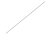

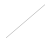

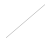

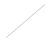

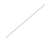

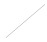

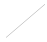

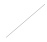

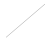

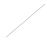

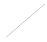

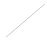

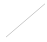

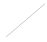

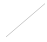

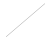

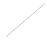

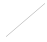

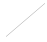

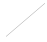

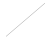

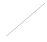

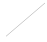

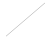

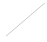

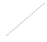

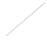

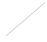

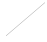

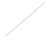

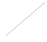

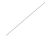

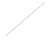

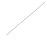

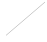

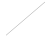

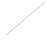

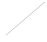

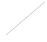

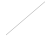

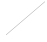

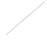

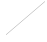

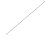

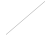

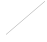

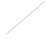

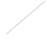

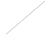

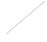

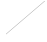

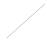

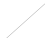

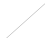

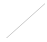

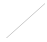

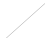

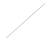

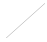

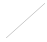

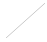

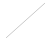

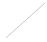

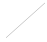

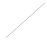

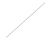

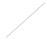

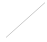

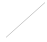

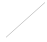

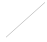

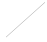

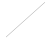

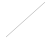

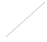

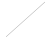

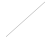

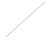

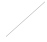

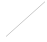

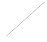

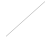

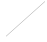

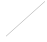

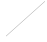

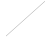

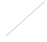

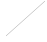

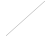

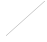

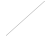

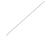

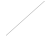

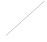

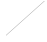

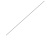

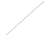

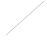

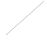

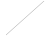

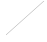

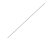

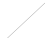

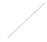

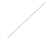

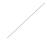

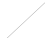

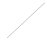

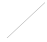

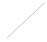

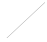

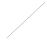

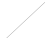

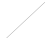

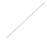

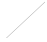

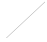

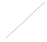

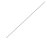

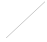

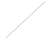

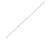

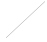

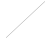

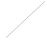

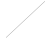

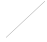

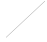

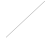

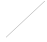

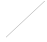

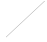

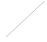

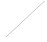

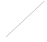

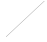

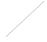

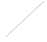

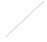

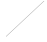

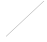

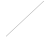

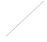

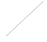

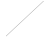

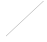

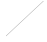

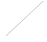

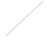

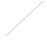

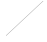

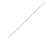

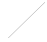

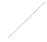

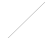

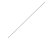

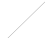

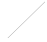

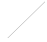

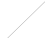

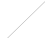

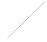

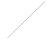

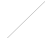

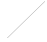

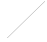

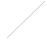

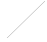

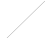

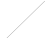

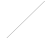

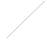

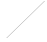

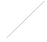

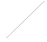

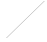

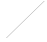

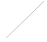

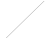

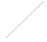

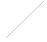

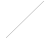

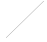

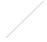

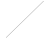

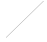

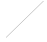

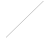

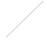

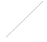

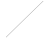

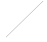

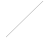

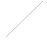

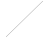

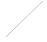

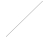

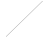

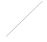

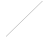

In [21]:
canvas = np.zeros((nbins, nbins), dtype=np.float32) #The complete img
for i,a in enumerate(np.linspace(amin, amax, nbins)):
    for j,b in enumerate(np.linspace(bmin, bmax, nbins)):
        p = getProb(a,b)
        a_r = ai[i,j] #In real numbers
        b_r = bi[i,j]
        #print(i,j,a_r,b_r,p)
        fig = plt.figure(figsize=(nbins/10,nbins/10),dpi=10,)
        plt.plot([-10.0, 10.0], [a_r*xmin+b_r, a_r*xmax+b_r], color='gray', alpha = 1)
        plt.xlim((-10,10))
        plt.ylim((-30,30))
        plt.axis('off')
        dat = (255 - fig2data(fig)[:,:,0])/255.0 #BW one channel is good enough
        canvas += p * dat
plt.imshow(canvas)
canvas      

(0.44326484, 0.0, (50, 50))

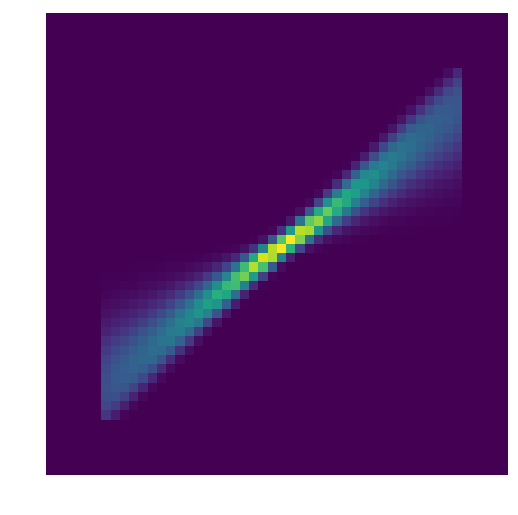

In [32]:
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.axis('off')
np.max(canvas), np.min(canvas), canvas.shape

(-30, 30)

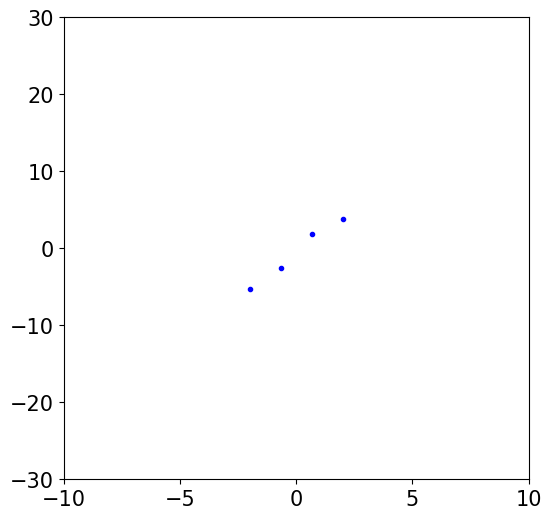

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(x,y, marker='.', color='blue')
plt.xlim((-10,10))
plt.ylim((-30,30))


In [119]:
canvas[12,7],canvas[12,nbins-7],nbins

(0.0034258394, 0.0034310666, 50)

array([[5.1698713 , 5.1698713 , 0.        , ..., 0.        , 5.6583056 ,
        5.6583056 ],
       [5.1798463 , 5.1798463 , 5.1698713 , ..., 5.6583056 , 5.6682763 ,
        5.6682763 ],
       [0.34445733, 5.5143366 , 5.1798463 , ..., 5.6682763 , 6.0027742 ,
        0.34445745],
       ...,
       [0.34445733, 6.6539288 , 6.6450076 , ..., 6.1565423 , 6.1654673 ,
        0.34445745],
       [6.6450076 , 6.6450076 , 6.30946   , ..., 5.821002  , 6.1565423 ,
        6.1565423 ],
       [6.30946   , 6.30946   , 0.        , ..., 0.        , 5.821002  ,
        5.821002  ]], dtype=float32)

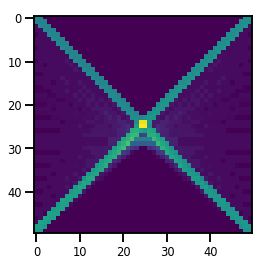

In [404]:
canvas = np.zeros((nbins, nbins), dtype=np.float32) #The complete img
for i,a in enumerate(np.linspace(amin, amax, nbins)):
    for j,b in enumerate(np.linspace(bmin, bmax, nbins)):
        img_ln = np.zeros((nbins, nbins), dtype=np.float32)
        p = getProb(i,j)
        a_r = ai[i,j] #In real numbers
        b_r = bi[i,j]
        xmin = 0
        xmax = nbins
        #canvas = np.zeros((nbins, nbins), dtype=np.float32) #The complete img
        #a_r =  0
        #b_r =  0.1
        x0 = 0
        x1 = nbins-1
        xmin = -20
        xmax = +20
        ymin = -20
        ymax = +20
        y0 = nbins - toBin(a_r*xmin+b_r, ymin,ymax) - 1
        y1 = nbins - toBin(a_r*xmax+b_r, ymin,ymax) - 1
        #print(y0,y1,a_r*amin+b_r,p)
        rr,cc,val = line_aa(y0,x0,y1,x1)
        canvas[rr,cc] += 100*p
        #plt.imshow(canvas)
        #canvas
plt.imshow(canvas)
canvas      

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.29289323, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.29289323, 1.        , 0.29289323],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.29289323, 1.        , 0.29289323, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.29289323, 1.        , 0.29289323, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.29289323,
        1.        , 0.29289323, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.29289323, 1.        ,
        0.29289323, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.29289323, 1.        , 0.29289323,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.29289323, 1.       

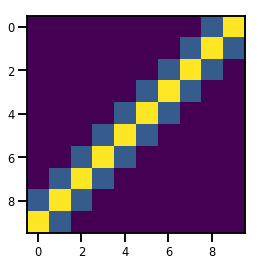

In [354]:
canvas = np.zeros((nbins, nbins), dtype=np.float32) #The complete img
a_r =  1
b_r =  0.1
x0 = 0
x1 = nbins-1
xmin = -10
xmax = +10
ymin = -10
ymax = +10
y0 = nbins - toBin(a_r*xmin+b_r, ymin,ymax) - 1
y1 = nbins - toBin(a_r*xmax+b_r, ymin,ymax) - 1
#print(y0,y1,a_r*amin+b_r)
rr,cc,val = line_aa(y0,x0,y1,x1)
canvas[rr,cc] += val
plt.imshow(canvas)
canvas